Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

------------

## Reading Material

Some reading material to get familiarised with word2vec approach.

 - A very good introduction on word2vec can be found in [this blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).
 - [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
 - [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
 - An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara.
 - [TensorFlow word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec).
 - [Udacity Deel Leanring Embeddings notebook](https://github.com/udacity/deep-learning/tree/master/embeddings).
 
___

## Short Theory Introduction

### Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](images/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](images/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='images/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.


## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. 

Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model (Section 3.1 and 3.2 in [Mikolov et al.](http://arxiv.org/pdf/1301.3781.pdf)). Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. 

The two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram are depicted in the following graph:

<img src="images/word2vec_architectures.png" width="500">

We will first work with the skip-gram model and later with the CBOW. In the skip-gram model, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

In [1]:
# These are all the modules we'll be using later. 
# Make sure you can import them before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import shutil # high level file operations

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    # Go to parent directory and then go to data directory
    fpath = os.getcwd()
    cpath = os.path.abspath(os.path.join(fpath, os.pardir))
    cpath = os.path.join(cpath, 'data')
    cpath = os.path.join(cpath, filename)
    # create boolean variable if file exists
    cpathl = os.path.exists(cpath)
    if not cpathl:
        filename, _ = urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
    else:
        statinfo = os.stat(cpath)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
        
    if not cpathl:
        # After file has been verified move it to data folder
        fpath = os.path.join(fpath, filename)
        shutil.move(fpath, cpath)
    
    return(filename)

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    # Go to parent directory and then go to data directory
    fpath = os.getcwd()
    cpath = os.path.abspath(os.path.join(fpath, os.pardir))
    cpath = os.path.join(cpath, 'data')
    cpath = os.path.join(cpath, filename)
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(cpath) as f:
        # ZipFile.namelist() :: Returns a list of archive members by name.
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return (data)
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

Note: The UNK token is a special token used to capture out-of-vocabulary (OOV) words.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    # add most common words and their count as tupples in the list==count
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        # The dictionaty[word] gives the index of the word in the dictionary
        # ie the time it was added, hence entries start with most frequent word and go down
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        # data collects the indexes contained in dictionary
        # each data element represents the results/dictionary_index of the relevant words element
        data.append(index)
    count[0][1] = unk_count
    # reverses the dictionary entries
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return (data, count, dictionary, reverse_dictionary)

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del(words) # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5242, 3082, 12, 6, 195, 2, 3135, 46, 59, 156]


Let's Explore the data structures created by the previous function

In [5]:
print('data type is {} with length {}'.format(type(data), len(data)))
print(data[:24])

print('\ncount type is {} with length {}'.format(type(count), len(count)))
print(count[:6])

print('\ndictionary type is {} with length {}'.format(type(dictionary), len(dictionary)))
print(list(dictionary.items())[:6])
    
print('\nreverse_dictionary type is {} with length {}'.format(
    type(reverse_dictionary), len(reverse_dictionary)))
print(list(reverse_dictionary.items())[:6])

data type is <class 'list'> with length 17005207
[5242, 3082, 12, 6, 195, 2, 3135, 46, 59, 156, 128, 742, 477, 10603, 134, 1, 27559, 2, 1, 103, 855, 3, 1, 15192]

count type is <class 'list'> with length 50000
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201)]

dictionary type is <class 'dict'> with length 50000
[('gabaa', 47135), ('steppenwolf', 45225), ('nullified', 30107), ('totalling', 19614), ('siemens', 22245), ('olympians', 32333)]

reverse_dictionary type is <class 'dict'> with length 50000
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in')]


- Why do we need to return the data variable?
   It is used later to generate data batches.
   
   Data is a list of indexes in the dictionary for all the words in our corpus. It either points to UNK or to a most_common_word entry in the dictionary.

Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    Function to generate a batch from the dataset.
    
    Args:
        batch_size: size of the batch to be created
        num_skips: How many times to reuse an input to generate a label.
        skip_window: radius of the window of word2vec/skipgram model 
    """
    global data_index
    # assert % == 0 because we later iterate over that //
    assert batch_size % num_skips == 0
    # num_skips <= 2*skip_window so our exclusions later don't break down 
    # because there are not enough words to create (word, label) pairs.
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # https://docs.python.org/3.5/library/collections.html#collections.deque
    # deque :list-like container with fast appends and pops on either end
    buffer = collections.deque(maxlen=span)
    # First for loop gets numbers/indexes from data object so they can be used in next loop
    for __ in range(span):
        buffer.append(data[data_index])
        # data_index is global variable and the next line iterates it
        # up to the end of the dataset and then at start
        data_index = (data_index + 1) % len(data)
    # loop to create batch data
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        # We divide by num skips for i but now we iterate over them!
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            # appends word that will become label so that it is not picked in the next iteration
            targets_to_avoid.append(target)
            ### create word+label:
            # batch always picks the skip_window entry from buffer
            # ?why? it has to do with move step?
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        # this adds a word at the end but removes one at the beginning (from buffer)!
        buffer.append(data[data_index])
        # data index moves with buffer - just like initialisation
        # in previous for loop.
        data_index = (data_index + 1) % len(data)
    return (batch, labels)

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'a', 'originated', 'originated', 'term', 'of', 'as']


In [7]:
for num_skips, skip_window in [(1, 1), (1, 3), (1, 4)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print(batch)
    print(labels)


with num_skips = 1 and skip_window = 1:
    batch: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    labels: ['as', 'originated', 'term', 'a', 'abuse', 'of', 'used', 'against']
[3082   12    6  195    2 3135   46   59]
[[  12]
 [3082]
 [ 195]
 [   6]
 [3135]
 [   2]
 [  59]
 [ 156]]

with num_skips = 1 and skip_window = 3:
    batch: ['a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early']
    labels: ['originated', 'of', 'as', 'used', 'of', 'abuse', 'working', 'used']
[   6  195    2 3135   46   59  156  128]
[[3082]
 [   2]
 [  12]
 [  59]
 [   2]
 [3135]
 [ 742]
 [  59]]

with num_skips = 1 and skip_window = 4:
    batch: ['term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
    labels: ['first', 'used', 'of', 'term', 'early', 'first', 'first', 'early']
[ 195    2 3135   46   59  156  128  742]
[[ 46]
 [ 59]
 [  2]
 [195]
 [128]
 [ 46]
 [ 46]
 [128]]


## Train a skip-gram model.

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

# with graph.as_default(), tf.device('/cpu:0'):
# why use cpu explicitely?
with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights,
                                   biases=softmax_biases,
                                   inputs=embed,
                                   labels=train_labels,
                                   num_sampled=num_sampled,
                                   num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [9]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.145626
Nearest to system: fishermen, suicide, occultist, walls, sufis, mannered, chalcedonian, downside,
Nearest to there: keel, taoiseach, bae, poul, ollie, hmac, nihilism, astrologers,
Nearest to as: bua, wisconsin, patriarch, ergodic, partaking, halting, atom, jacobites,
Nearest to more: blyth, mikhail, circumnavigate, habitus, unaided, toomer, watched, pejoratively,
Nearest to most: wizardry, doings, customers, engelbert, kammu, faced, growing, hinders,
Nearest to from: immunoglobulin, brigade, ramparts, mexico, hottest, traversed, darren, alomari,
Nearest to eight: morphemes, population, spears, cascades, mesmer, compagnie, finalists, professor,
Nearest to four: combustion, prized, precludes, schleicher, romulus, fort, bionic, pivot,
Nearest to use: lamarr, chandragupta, evidences, claudian, vacuum, grab, obliged, ger,
Nearest to would: madrigals, taraza, fresh, intestine, discerning, pfa, warm, disputes,
Nearest to some: mcfarland, harmonious

Average loss at step 52000: 3.437006
Average loss at step 54000: 3.430390
Average loss at step 56000: 3.440542
Average loss at step 58000: 3.393925
Average loss at step 60000: 3.391485
Nearest to system: systems, suicide, listening, anchorage, network, greensboro, gladiatorial, nonprofit,
Nearest to there: they, it, he, now, still, this, often, also,
Nearest to as: when, aiken, hbox, became, saigon, before, saltpeter, capricious,
Nearest to more: less, most, very, rather, longer, greater, homage, assessments,
Nearest to most: more, many, some, particularly, domestic, roles, examiners, less,
Nearest to from: through, into, since, labiodental, hottest, emirs, after, sleek,
Nearest to eight: nine, six, seven, four, five, three, zero, one,
Nearest to four: six, five, eight, seven, three, nine, zero, two,
Nearest to use: size, cause, limit, most, swastika, form, alma, wilhelmina,
Nearest to would: will, could, may, can, must, should, might, cannot,
Nearest to some: many, several, these, eac

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

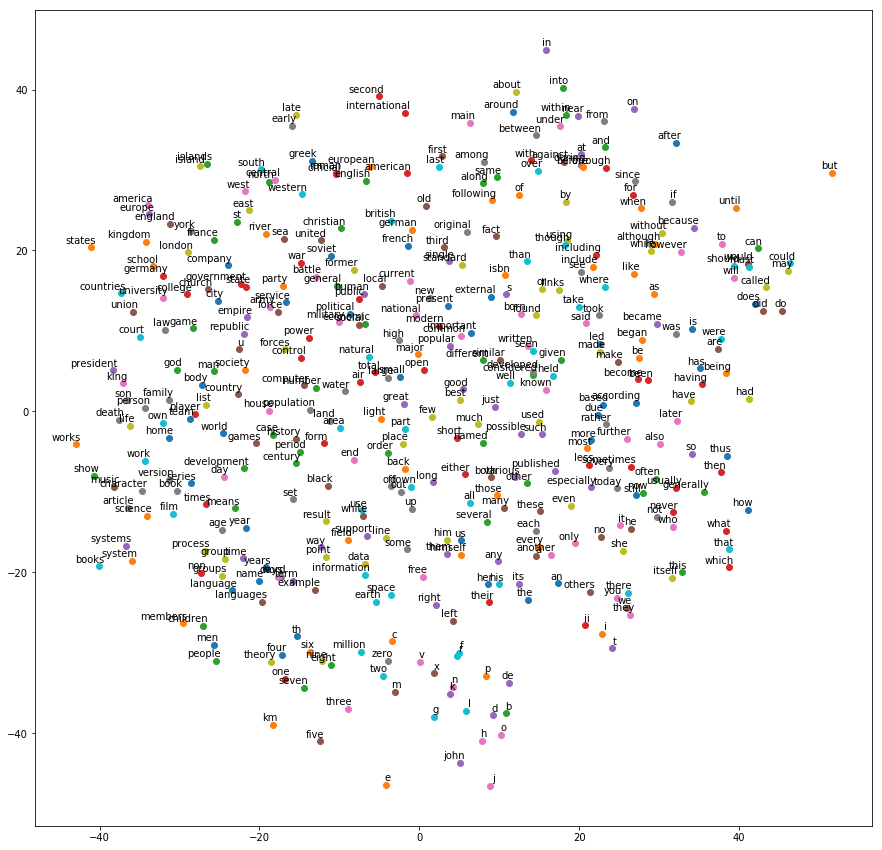

In [11]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [12]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        # iterate to the next buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))  
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
###skip_window = 1 # How many words to consider left and right.
###num_skips = 2 # How many times to reuse an input to generate a label.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights=softmax_weights, 
            biases=softmax_biases,
            inputs=tf.reduce_sum(embeds, 1),
            labels=train_labels, 
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, bag_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.601776
Nearest to state: accrington, fin, syndicated, reconciled, zach, combatants, damme, montju,
Nearest to a: productive, madison, eliminating, prowess, lewiston, servlet, erik, adenauer,
Nearest to been: tice, freedmen, cruel, oversee, rumford, milos, runs, earthquakes,
Nearest to not: parishioners, ieung, tribal, mortis, fantastical, indonesian, irbms, sauce,
Nearest to called: olof, informant, qc, almost, jingle, slate, atom, tswana,
Nearest to years: bigger, mira, alleviating, whim, synods, xxxiii, athos, crag,
Nearest to see: jerky, fondation, oeuvre, usmc, exp, medline, underway, deposition,
Nearest to new: flourishing, aerobatic, ying, oscillators, paladin, bosom, damping, silverstein,
Nearest to states: unauthorized, pital, censuses, thabit, reorganization, mayer, mic, ms,
Nearest to other: business, differently, photographic, replay, khalq, brainchild, dam, blackstone,
Nearest to up: samuelson, tortuous, lucky, nagano, affectionately, l

Average loss at step 52000: 3.089522
Average loss at step 54000: 3.087258
Average loss at step 56000: 2.916493
Average loss at step 58000: 3.015235
Average loss at step 60000: 3.052750
Nearest to state: government, base, climbs, congress, engages, chills, fon, governor,
Nearest to a: another, the, any, every, no, jeet, alvarez, legalizing,
Nearest to been: become, existed, occurred, come, remained, ford, begun, grown,
Nearest to not: never, still, nothing, elected, without, detectives, billie, unable,
Nearest to called: considered, used, referred, named, known, included, introduced, produced,
Nearest to years: months, days, decades, times, centuries, minutes, year, versions,
Nearest to see: includes, cem, roddick, known, maga, include, usmc, aafc,
Nearest to new: specific, particular, oa, single, medieval, old, katsura, different,
Nearest to states: kingdom, nations, countries, tribes, provinces, mariners, terrace, organizations,
Nearest to other: various, rather, fewer, others, differ

Re-use code to visualise embeddings

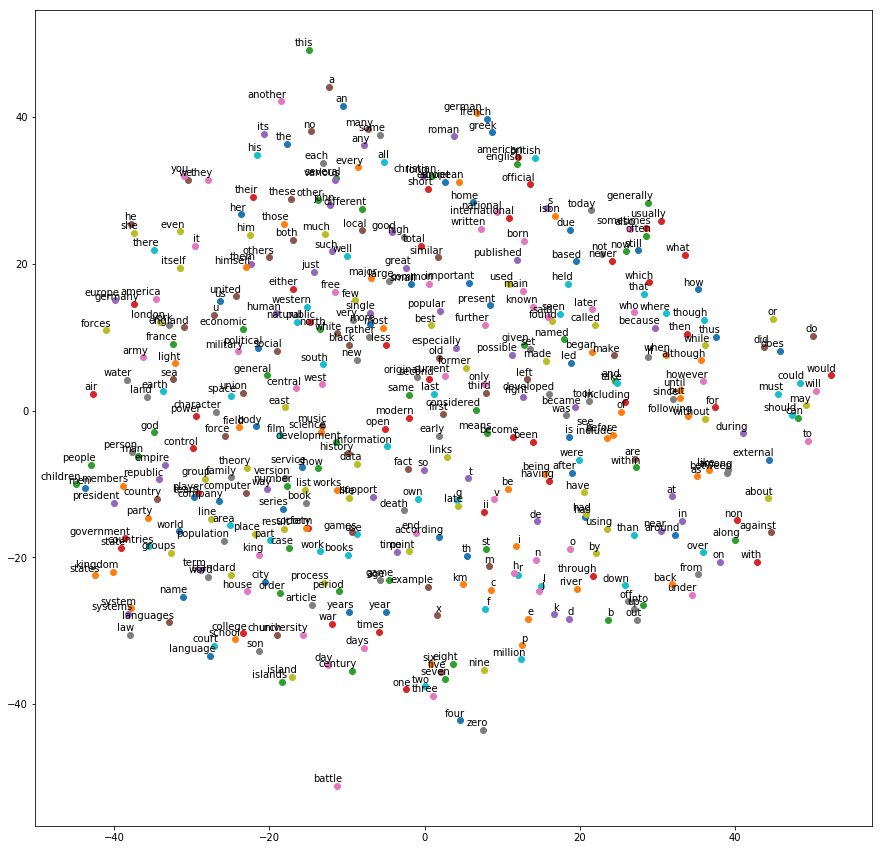

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Further work:

- Explore the GloVe technique( [Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)). A good implementation is [here](https://github.com/thushv89/word2vec/blob/master/word2vec_GloVe.ipynb) as described [here](http://www.thushv.com/natural_language_processing/glove-global-vectors-for-word-representation/).
- Explore whether representing words as punctuations helps.
- Explore better model performance metrics (e.g. training and validation datasets).